## Two Sample Test in Example 3.2, Matthews & Taylor

### 0. Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### 1. Data

Text(0.5, 1.0, 'Scatterplot of sample X')

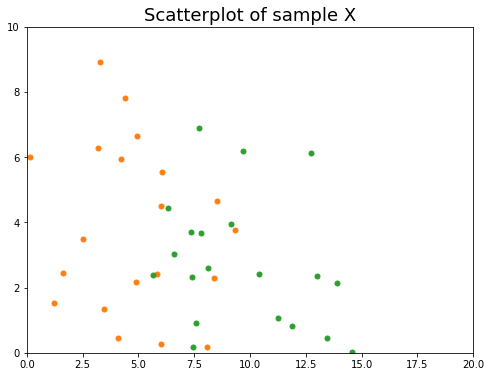

In [2]:
X = np.array([[4.91, 2.16], [6.05, 5.54], [3.48, 1.35], [8.09, 0.18], [2.53, 3.49],
             [1.62, 2.46], [8.37, 2.29], [3.17, 6.27], [6.02, 4.51], [8.50, 4.65],
             [4.21, 5.93], [0.15, 5.99], [9.31, 3.77], [4.10, 0.45], [5.83, 2.42],
             [6.00, 0.27], [3.30, 8.93], [4.38, 7.81], [4.93, 6.64], [1.22, 1.54]])

Y = np.array([[13.90, 2.13], [7.71, 6.89], [9.67, 6.20], [7.56, 0.90], [10.39, 2.43],
             [13.47, 0.45], [14.55, 0.01], [7.46, 0.18], [11.25, 1.08], [13.00, 2.37],
             [6.33, 4.44], [11.86, 0.83], [7.42, 2.31], [9.15, 3.94], [12.73, 6.12],
             [6.58, 3.04], [7.34, 3.69], [8.12, 2.59], [7.79, 3.68], [5.65, 2.40]])

# I have changed a data point because it was far away

N = X.shape[0]
M = Y.shape[0]

plt.figure(figsize=(8,6))
plt.plot(X[:,0], X[:,1], 'o', color = 'C1', label = 'Data X', zorder = 1, ms = 5)
plt.plot(Y[:,0], Y[:,1], 'o', color = 'C2', label = 'Data Y', zorder = 1, ms = 5)


plt.xlim(0,20)
plt.ylim(0,10)

plt.title('Scatterplot of sample X', fontsize=18)
# plt.legend(fontsize=18)
# plt.grid()

### 2. Cutting functions: Class definition

In [3]:
# each function is arbitrary and takes one of the components of the corresponding (x1, x2)
H = np.array([1,1,0,1,1,1,0,1,1,0,0,0,1,0,1,0,1,0,0,1])
# H = np.array([0,1,0,1,1,1,0,1,0,0,1,0,1,0,1,1,0,0,1,0])

# define the permutaions (arbitrary)
K = np.array([10, 5, 15, 3, 7, 12, 18, 2, 4, 6, 8, 11, 13, 16, 19, 1, 9, 14, 17, 20])

# the class allow to define both cutting functions and permutations, in order to execute a bisection method or randomly
class CPfunctions():
    def __init__(self, 
                 Ndata, cut = None, perm = None):
        self.N = Ndata   # size of the data
    def permutation(self, random = False):
        """
        Define the permutation index for a bisection method, or in a random fashion if random is True
        """
        N = self.N
        K = np.arange(1,N+1)
        new_K = []
        if random:
            np.random.shuffle(K)
            new_K = K
        else:
            k_first = list(K)
            k_first.sort()
            K_List = [k_first]
            K_marker = [0]  # index that says if the corresponding K_List has been partitioned or not

            for i in range(N):
                # choose list to divide
                for j in range(len(K_List)):
                    if K_marker[j] == 0 and len(K_List[j]) >= 1:
                        length_K = len(K_List[j])
                        # choose position of new_K in the list
                        K_position = (length_K+1)//2 -1   # the middle (even) or the first integer greater than the middle (odd)
                        new_K.append(K_List[j][K_position])
                        # split the existing array            
                        K_List.append(K_List[j][:K_position])
                        K_List.append(K_List[j][K_position+1:])
                        K_marker[j] = 1
                        K_marker.append(0)
                        K_marker.append(0)
                        # now add elements to H_new
                        break
                        
        self.perm = np.array(new_K)
        
    def cutting(self, random = False):
        N = self.N
        H = np.random.randint(0, 2, N)
        K = self.perm
        new_H = H
        if not random:            
            H_counter = []   # counter to asign values of H
            h = 0
            while sum(H_counter) <= len(new_H):
                H_counter.append(2**h)
                h = h+1

            H_value = [0]*len(H_counter)    # values of H to asign
            for i in range(len(H_value)):
                if i%2 == 1:
                    H_value[i] = 1

            # for each element in K, asign the corresponding element in H

            for i in range(N):
                for m in range(len(H_value)):
                    if i+1 <= sum(H_counter[:m+1]):
                        new_H[K[i]-1] = H_value[m]
                        break
                        
        self.cut = np.array(new_H)


In [4]:
Lists = CPfunctions(N)
Lists.permutation()
Lists.cutting()
K = Lists.perm
H = Lists.cut
print(K)
print(H[K-1])


[10  5 15  2  7 12 18  1  3  6  8 11 13 16 19  4  9 14 17 20]
[0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0]


### 3. Partition: Class definition

### Let's define a class to work with the blocks

In [5]:
class block():
    def __init__(self, 
                 vertices = None, 
                 elements = None, 
                 stats = None, 
                 parent = None, 
                 leftChild = None, 
                 rightChild = None, 
                 prefChild = None):
        self.vertices = vertices   # array with 2 bidimensional elements, corresponding to the vertices of the block
                                   # vertices must be ordered starting from the left bottom vertix and finishing with the
                                   # right top vertix
                                   # the array must have two rows and two columns (bidimensional case)
        self.elements = elements   # array with the points that belong to the block. Each row contains an element and each
                                   # column is a dimension (in this case, bidimensional)
        self.stats = np.sort(stats) # array with index of blocks
        self.parent = parent       # parent of the block
        self.leftChild = leftChild
        self.rightChild = rightChild
        self.prefChild = prefChild
    
    def plot(self, color = 'C0', lw = 1, size = 12, print_num = True):
        plt.plot(self.vertices[:,0], np.ones(2)*self.vertices[0,1], color = color, lw = lw)
        plt.plot(np.ones(2)*self.vertices[1,0], self.vertices[:,1], color = color, lw = lw)
        plt.plot(self.vertices[:,0], np.ones(2)*self.vertices[1,1], color = color, lw = lw)
        plt.plot(np.ones(2)*self.vertices[0,0], self.vertices[:,1], color = color, lw = lw)
        xplot = (self.vertices[0,0]+self.vertices[1,0])/2
        yplot = (self.vertices[0,1]+self.vertices[1,1])/2
        if self.stats.size == 1 and print_num:
            plt.text(xplot, yplot, str(self.stats[0]), fontsize = size)

        
    def split(self, axis, korder):
        """
        This method split a Block and creates two child blocks, making the partition on the korder th statistic
        axis: indicates wheter it is along the X axis (vertical, 0) or the Y axis (horizontal, 1)
        korder: is the order statistic to make the partition
        """
        # select the dimension to sort
        Xele = self.elements[:,axis]
        # select the kth order statistic
        Xorder = np.sort(Xele)
        minStat = min(self.stats)
        korder = korder - minStat
        xstat = Xorder[korder]
        # divide the stats
        statsL = self.stats[:korder+1]
        statsR = self.stats[korder+1:]
        # create the elements and vertices of each block
        Relements = np.empty((0, 2))
        Lelements = np.empty((0, 2))
        
        # add elements to vertices and elements for each case
        if axis == 0:
            Lvertices = np.array([self.vertices[0,:], [xstat, self.vertices[1,1]]])
            Rvertices = np.array([[xstat, self.vertices[0,1]], self.vertices[1,:]])
            # now we move on the elements of the parent block and select wich ones go to the left and right child
            for l in range(self.elements.shape[0]):
                if Xele[l] < xstat:
                    Lelements = np.append(Lelements, [self.elements[l, :]], axis = 0)   # add the new element as a row
                elif Xele[l] > xstat:
                    Relements = np.append(Relements, [self.elements[l, :]], axis = 0)   # add the new element as a row
                else:
                    Pchild = [self.elements[l,:]]  # chosen kth order 
        elif axis == 1:
            Lvertices = np.array([self.vertices[0,:], [self.vertices[1,0], xstat]])
            Rvertices = np.array([[self.vertices[0,0], xstat],self.vertices[1,:]])
            # now we move on the elements of the parent block and select wich ones go to the left and right child
            for l in range(self.elements.shape[0]):
                if Xele[l] < xstat:
                    Lelements = np.append(Lelements, [self.elements[l, :]], axis = 0)   # add the new element as a row
                elif Xele[l] > xstat:
                    Relements = np.append(Relements, [self.elements[l, :]], axis = 0)   # add the new element as a row
                else:
                    Pchild = [self.elements[l,:]]   # chosen kth order 
                
        # create the childs of the block
        Rchild = block(vertices = Rvertices, elements = Relements, stats = statsR, parent = self)  
        # right side or up side (the greaters elements)
        Lchild = block(vertices = Lvertices, elements = Lelements, stats = statsL, parent = self)   
        # left side or down side (the smaller elements)
        
        # asociate the childs to the parten
        self.rightChild = Rchild
        self.leftChild = Lchild
        self.prefChild = Pchild
        # return the place where the partition was made
        return xstat
    
    def belong(self, x):
        nx = x.shape[0]
        out = True
        for i in range(nx):
            out = out and self.vertices[0,i] < x[i] <= self.vertices[1,i]
        return out
        
        

[4 5 6 7]
[8]
[[1.  1. ]
 [3.  2. ]
 [2.5 1.5]]
[[4.  3.5]]
[2. 3.]
False


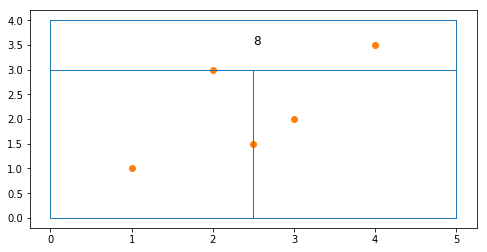

In [6]:
# some test to the class
Vertix = np.array([[0,0], [5,4]])
Elements = np.array([[1,1], [2,3], [4,3.5], [3,2],[2.5,1.5]])
stats = range(4, Elements.shape[0]+4)   # stats goes from 4 to 8
Bloque = block(vertices = Vertix, elements = Elements, stats = stats)

fig = plt.figure(figsize=(8,4))
# Bloque.plot(color = 'g')
plt.plot(Elements[:,0], Elements[:,1], 'o', color = 'C1')

Bloque.split(axis = 1, korder = 7)
BloqueL1 = Bloque.leftChild
BloqueR1 = Bloque.rightChild
print(BloqueL1.stats)
print(BloqueR1.stats)
print(BloqueL1.elements)
print(BloqueR1.elements)
print(Bloque.prefChild[0])

BloqueL1.split(axis = 0, korder = 5)
BloqueL11 = BloqueL1.leftChild
BloqueR11 = BloqueL1.rightChild


BloqueL1.plot()
BloqueR1.plot()
BloqueL11.plot()
BloqueR11.plot()

print(Bloque.belong(np.array([6,5])))

### 4. Partition: general case
### We proceed to use the block class to apply the partition in an iterative loop

In [7]:
# create list with blocks
First_Block = block(vertices = np.array([[0,0],[15,15]]), elements = X, stats = range(1,N+2))

Blocks_List = [First_Block]

step = 20

for i in range(step):
    # search the last block that has the K[i] stat
    for j in range(len(Blocks_List)):
        if K[i] in Blocks_List[j].stats and Blocks_List[j].leftChild == None:
            Blocks_List[j].split(axis = H[K[i]-1], korder = K[i])
            Blocks_List.extend([Blocks_List[j].leftChild, Blocks_List[j].rightChild])
            break

### Now we plot the finals blocks

Point [array([4.38, 7.81])] was selection 1 in iteration 1
Point [array([2.53, 3.49])] was selection 2 in iteration 2
Point [array([5.83, 2.42])] was selection 3 in iteration 3
Point [array([1.62, 2.46])] was selection 4 in iteration 4
Point [array([3.17, 6.27])] was selection 5 in iteration 5
Point [array([6.  , 0.27])] was selection 6 in iteration 6
Point [array([6.05, 5.54])] was selection 7 in iteration 7
Point [array([1.22, 1.54])] was selection 8 in iteration 8
Point [array([4.1 , 0.45])] was selection 9 in iteration 9
Point [array([0.15, 5.99])] was selection 10 in iteration 10
Point [array([4.21, 5.93])] was selection 11 in iteration 11
Point [array([4.91, 2.16])] was selection 12 in iteration 12
Point [array([8.09, 0.18])] was selection 13 in iteration 13
Point [array([6.02, 4.51])] was selection 14 in iteration 14
Point [array([9.31, 3.77])] was selection 15 in iteration 15
Point [array([3.48, 1.35])] was selection 16 in iteration 19
Point [array([3.3 , 8.93])] was selection 

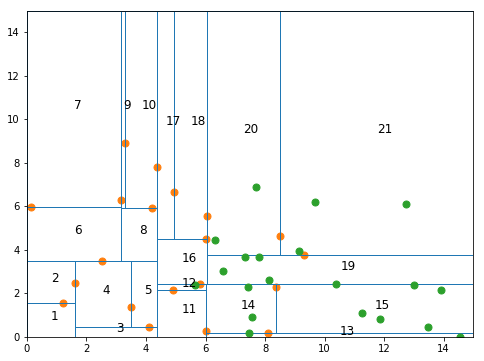

In [8]:
# plot
fig = plt.figure(figsize=(8,6))
plt.plot(X[:,0], X[:,1], 'o', color = 'C1', ms = 7)

plt.xlim(0,15)
plt.ylim(0,15)

# create list of final blocks
Blocks_Final = []
block_ref = list()

for j in range(len(Blocks_List)):
    if Blocks_List[j].leftChild == None:
        Blocks_Final.extend([Blocks_List[j]])
        Blocks_List[j].plot(print_num = True)
        block_ref.append(Blocks_List[j].stats)
        
#fig.savefig('Figures (png)/Step'+str(step)+'b.png',        # nombre archivo
#            format='png',        # formato
#            bbox_inches='tight',  # elimina bordes vacios
#           )

# Defining the selection list
cont = 1
for i in range(len(Blocks_List)):
    if Blocks_List[i].prefChild != None:
        print('Point', Blocks_List[i].prefChild, 'was selection', cont, 'in iteration', i+1)
        cont += 1


plt.plot(Y[:,0], Y[:,1], 'o', color = 'C2', ms = 7)

print(Blocks_Final[12].stats)

### 5. Test if both data come from the same distribution

In [9]:
# order the final blocks, so in the list of blocks they will be on the order corresponding to their statistics

Blocks_Order = []
N_Blocks = len(Blocks_Final)
Assigned_Blocks = 0
i = 0
while Assigned_Blocks < N_Blocks:
    if Blocks_Final[int(i%N_Blocks)].stats[0] == Assigned_Blocks+1:
        Blocks_Order.extend([Blocks_Final[i%N_Blocks]])
        Assigned_Blocks = Assigned_Blocks + 1
    i = i + 1  # search in another block
      
print(Blocks_Order[12].belong(np.array([14.55,0.01])))


True


#### Counting number of samples from Y that fall on each block

In [10]:
Y_copy = Y   # copy Y to eliminate the elements already assigned to a block
Ma = np.zeros(len(Blocks_Order))  # 

# calculate the values of m_{alpha} -> esto basta para hacer el test
for k in range(len(Blocks_Order)):
    i = 0
    while i < Y_copy.shape[0]:   # count the elements that belong to the k-th block
        if Blocks_Order[k].belong(Y_copy[i,:]):
            Ma[k] = Ma[k] + 1
            Y_copy = np.delete(Y_copy, i, axis = 0)
            i = i - 1
        i = i + 1
print(Ma)
print(Y.shape[0])
print(Y_copy)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 2. 5. 0. 0. 0. 5. 2. 3.]
20
[]


1.0
[0.00000000e+00 1.52343336e-10 2.89452338e-08 1.64987832e-06
 4.20718973e-05 5.72177803e-04 4.57742242e-03 2.28871121e-02
 7.43831144e-02 1.61163414e-01 2.36373008e-01 2.36373008e-01
 1.61163414e-01 7.43831144e-02 2.28871121e-02 4.57742242e-03
 5.72177803e-04 4.20718973e-05 1.64987832e-06 2.89452338e-08
 1.52343336e-10]


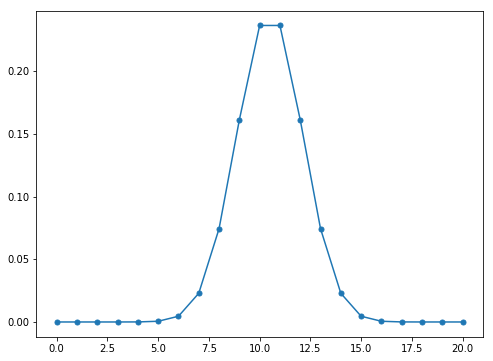

In [11]:
# let's calculate the S distribution, under H0
import operator as op
from functools import reduce

def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer / denom

def prob_M_null(s, N, M):
    """
    Calculate probabilitie that exactly s of the ma's are 0, under H0
    N is the size of data that defined the blocks
    M is the size of new data that is being compared
    """
    num = ncr(N+1, s)*ncr(M-1, N-s)
    den = ncr(M+N, N)
    return num/den

s_prob = np.zeros(N+1)  # there are N + 1 blocks

if N >= M-1:
    for s in range(N-M+1, N+1):
        s_prob[s] = prob_M_null(s, N, M)
else:
    for s in range(0, N+1):
        s_prob[s] = prob_M_null(s, N, M)
        
# plot
fig = plt.figure(figsize=(8,6))
plt.plot(range(0, N+1), s_prob, 'o-', color = 'C0', ms = 5)

# plt.xlim(0,15)
# plt.ylim(0,1)

print(sum(s_prob))
print(s_prob)


14 0.028080463216121194


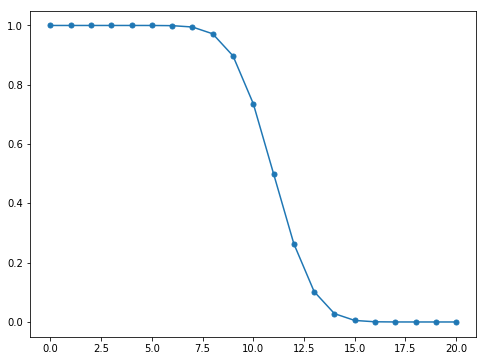

In [12]:
# let's calculate the complement cumulative distribution, under H0 
# (we calculate the probability to have at least s m_a's that are 0)
S_prob = np.zeros(N+1)
for s in range(N+1):
    S_prob[s] = sum(s_prob[s:])
    
fig = plt.figure(figsize=(8,6))
plt.plot(range(0, N+1), S_prob, 'o-', color = 'C0', ms = 5)

# find the element with significance level closer to epsi
epsi = 0.05
index = (np.abs(S_prob-epsi)).argmin()
if S_prob[index] > epsi:
    index = index + 1
    
print(index, S_prob[index])

In [13]:
# finally count the null elements
M_nulls = np.count_nonzero(Ma==0)
print(M_nulls)
if M_nulls < index:
    print('The samples were generated from the same distribution')
else:
    print('The samples were generated from different distributions')

14
The samples were generated from different distributions
